# Imports

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import joblib



print("done")

done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv("/content/drive/MyDrive/Grad Project/preprocessed_2.xls")
data.head()

,claim_status,phase3_cleaned,lemmas
0,claim,elect donald trump this week but only after o...,elect donald trump this week but only after ...
1,Supported claim,reuters published an article saying berlin the...,reuter publish an article say berlin the germa...
2,opinion,in our opinion humans physically cannot hum wh...,in our opinion human physically can not hum wh...
3,Supported claim,reuters published an article saying kampala ug...,reuter publish an article say kampala ugandan ...
4,opinion,my colleagues think that it is illegal to wast...,my colleague think that it be illegal to waste...


# Preperation

In [6]:
# encoding
le = LabelEncoder()
data['label'] = le.fit_transform(data['claim_status'])
data[['claim_status', 'label']].head()


,claim_status,label
0,claim,1
1,Supported claim,0
2,opinion,2
3,Supported claim,0
4,opinion,2


In [7]:
data.isna().sum()

,0
claim_status,0
phase3_cleaned,1
lemmas,1
label,0


In [8]:
data=data.dropna()
data.isna().sum()

,0
claim_status,0
phase3_cleaned,0
lemmas,0
label,0


In [9]:
print(data.shape)

(44050, 4)


In [10]:
X= data['lemmas']
y=data['label']

# split 1: training
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.3,random_state=42
                #,stratify=y
                                                   )

# split 2: validation (15%) + test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.5,  # 50% of the 30% = 15% of total
    random_state=42
    #,stratify=y_temp
                                               )

In [11]:
print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

Train: 30835 samples
Validation: 6607 samples
Test: 6608 samples


# BOW & TF-IDF

##  Model Selection

In [12]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Linear SVM": LinearSVC(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
}

In [13]:
def evaluate_model(model, X_train_vec, y_train, X_val_vec, y_val):
    start = time.time()
    model.fit(X_train_vec, y_train)
    end = time.time()
    train_time = end - start

    y_train_pred = model.predict(X_train_vec)
    y_val_pred = model.predict(X_val_vec)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)

    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted', zero_division=0)
    return round(train_time,2), train_acc, val_acc, precision, recall, f1

In [14]:
# BOW
bow_vectorizer = CountVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)

results = []

for name, model in models.items():
    train_time, train_acc, val_acc, precision, recall, f1 = evaluate_model(model, X_train_bow, y_train, X_val_bow, y_val)
    results.append(("BoW", 1000, name, train_time, train_acc, val_acc, precision, recall, f1))
    print(f"[BoW] {name} done.")


[BoW] Logistic Regression done.


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[BoW] Linear SVM done.
[BoW] Random Forest done.


In [15]:
# TF-IDF
max_feature_values = [50, 1000]

for mf in max_feature_values:
    tfidf = TfidfVectorizer(max_features=mf, ngram_range=(1,2), stop_words='english')
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_val_tfidf = tfidf.transform(X_val)

    for name, model in models.items():
        train_time, train_acc, val_acc, precision, recall, f1 = evaluate_model(model, X_train_tfidf, y_train, X_val_tfidf, y_val)
        results.append(("TF-IDF", mf, name, train_time, train_acc, val_acc, precision, recall, f1))
        print(f"[TF-IDF={mf}] {name} done.")


[TF-IDF=50] Logistic Regression done.
[TF-IDF=50] Linear SVM done.
[TF-IDF=50] Random Forest done.
[TF-IDF=1000] Logistic Regression done.
[TF-IDF=1000] Linear SVM done.
[TF-IDF=1000] Random Forest done.


In [16]:
results_df = pd.DataFrame(results, columns=[
    'Vectorizer', 'Max Features', 'Model', 'Train Time (s)',
    'Train Accuracy', 'Val Accuracy', 'Precision', 'Recall', 'F1'
])

print("\nAll Results Summary:")
results_df.round(3)


All Results Summary:


,Vectorizer,Max Features,Model,Train Time (s),Train Accuracy,Val Accuracy,Precision,Recall,F1
0,BoW,1000,Logistic Regression,5.76,0.968,0.954,0.956,0.954,0.954
1,BoW,1000,Linear SVM,17.06,0.971,0.957,0.958,0.957,0.957
2,BoW,1000,Random Forest,115.00,0.977,0.965,0.966,0.965,0.965
3,TF-IDF,50,Logistic Regression,0.54,0.706,0.709,0.774,0.709,0.709
4,TF-IDF,50,Linear SVM,0.37,0.714,0.716,0.775,0.716,0.720
5,TF-IDF,50,Random Forest,41.50,0.783,0.737,0.804,0.737,0.741
6,TF-IDF,1000,Logistic Regression,1.20,0.956,0.954,0.955,0.954,0.954
7,TF-IDF,1000,Linear SVM,1.01,0.967,0.962,0.963,0.962,0.962
8,TF-IDF,1000,Random Forest,118.91,0.977,0.967,0.968,0.967,0.967


In [17]:
def get_learning_data(vectorizer, X_train, y_train, title):
    X_vec = vectorizer.fit_transform(X_train)
    model = LinearSVC(class_weight='balanced', random_state=42)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_vec, y_train,
        cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    return train_sizes, train_scores.mean(axis=1), val_scores.mean(axis=1), title


# BoW and TF-IDF vectorizers
bow_vec = CountVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
tfidf_vec = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))

# Get learning data for both
train_sizes_bow, train_mean_bow, val_mean_bow, title_bow = get_learning_data(bow_vec, X_train, y_train, "BoW + SVM")
train_sizes_tfidf, train_mean_tfidf, val_mean_tfidf, title_tfidf = get_learning_data(tfidf_vec, X_train, y_train, "TF-IDF + SVM")


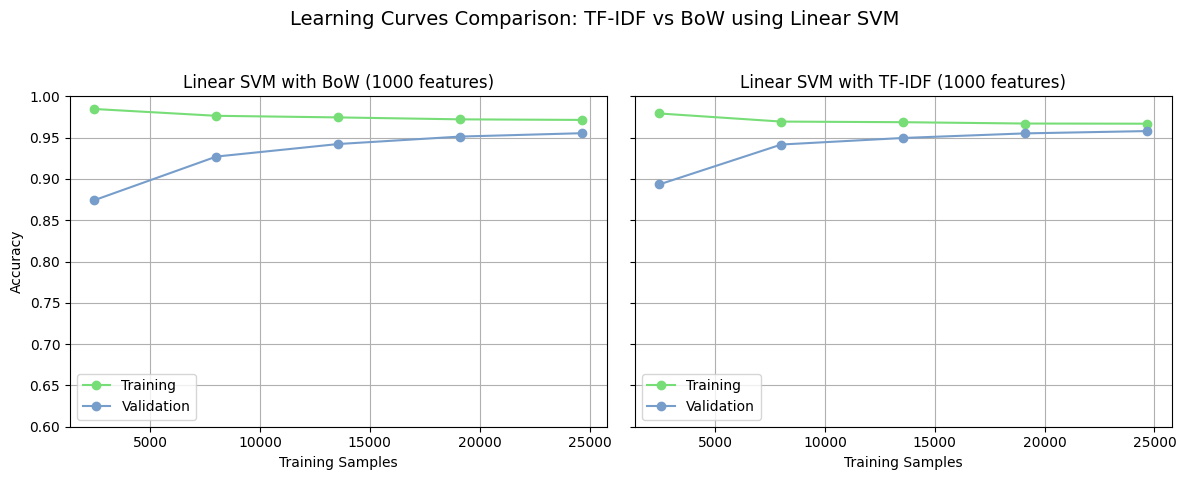

In [18]:
# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

axes[0].plot(train_sizes_bow, train_mean_bow, 'o-', label='Training', color='#77DD77')
axes[0].plot(train_sizes_bow, val_mean_bow, 'o-', label='Validation', color='#779ECB')
axes[0].set_title("Linear SVM with BoW (1000 features)")
axes[0].set_xlabel("Training Samples")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0.6, 1.0)
axes[0].legend()
axes[0].grid(True)

axes[1].plot(train_sizes_tfidf, train_mean_tfidf, 'o-', label='Training', color='#77DD77')
axes[1].plot(train_sizes_tfidf, val_mean_tfidf, 'o-', label='Validation', color='#779ECB')
axes[1].set_title("Linear SVM with TF-IDF (1000 features)")
axes[1].set_xlabel("Training Samples")
axes[1].set_ylim(0.6, 1.0)
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Learning Curves Comparison: TF-IDF vs BoW using Linear SVM", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Chosen Model:

In [19]:

tfidf = TfidfVectorizer(
    max_features=2000,      # top 2000 terms
    ngram_range=(1, 2),     # include both unigrams and bigrams
    #stop_words='english'    # remove common English stopwords
)

# Fit on training data
tfidf.fit(X_train)



TfidfVectorizer(max_features=2000, ngram_range=(1, 2))

In [20]:
# Transform all splits
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)

Train TF-IDF shape: (30835, 2000)
Test TF-IDF shape: (6608, 2000)


In [21]:
# Data Leakage Check


# if shapes are different
print("Train shape:", X_train_tfidf.shape)
print("Validation shape:", X_val_tfidf.shape)

#  if any text from validation appears in training
train_texts = set(X_train)
val_texts = set(X_val)
overlap = train_texts.intersection(val_texts)

print(f"Number of overlapping samples: {len(overlap)}")


Train shape: (30835, 2000)
Validation shape: (6607, 1000)
Number of overlapping samples: 0


## GridSearch

In [22]:
param_grid = {
    'C': [0.01, 0.1, 1, 5, 10],
    'loss': ['hinge', 'squared_hinge'],
    'tol': [1e-3, 1e-4, 1e-5],
    'max_iter': [10, 50, 100]
}

svm = LinearSVC(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'C': 10, 'loss': 'squared_hinge', 'max_iter': 10, 'tol': 0.0001}
Best F1 Score: 0.9966594687566372


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Training + Testing

In [23]:
C = 10
max_iter_total = 100
step = 10  # log results every 100 iterations
log_results = []


# Initialize model
svm_model = LinearSVC(
    C=C,
    loss='squared_hinge',
    class_weight='balanced',
    random_state=42,
    dual='auto',
    tol=0.001,
    verbose=1,
    max_iter=step
)


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Baseline CountVectorizer
bow = CountVectorizer(max_features=100)
X_train_bow = bow.fit_transform(X_train)
X_val_bow = bow.transform(X_val)

# Baseline model
logreg_bow = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg_bow.fit(X_train_bow, y_train)
pred_bow = logreg_bow.predict(X_val_bow)

print("Baseline Accuracy (CountVectorizer + Logistic Regression):", accuracy_score(y_val, pred_bow))


Baseline Accuracy (CountVectorizer + Logistic Regression): 0.8401695171787498


In [25]:
print("Starting incremental training and logging...\n")

for i in range(step, max_iter_total + step, step):
    start = time.time()

    # train for the current step
    svm_model.max_iter = i
    svm_model.fit(X_train_tfidf, y_train)
    end = time.time()
    train_time = round(end - start, 2)

    # Evaluate on training
    y_train_pred = svm_model.predict(X_train_tfidf)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        y_train, y_train_pred, average='weighted', zero_division=0
    )

    # Evaluate on test
    y_test_pred = svm_model.predict(X_test_tfidf)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average='weighted', zero_division=0
    )

    # Log results
    log_results.append((
        i, train_time,
        train_acc, train_prec, train_rec, train_f1,
        test_acc, test_prec, test_rec, test_f1
    ))

    print(f" Iter {i}: Train F1 = {train_f1:.4f} | Test F1 = {test_f1:.4f}")

Starting incremental training and logging...

[LibLinear]

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 Iter 10: Train F1 = 0.9997 | Test F1 = 0.9980
[LibLinear] Iter 20: Train F1 = 0.9997 | Test F1 = 0.9980
[LibLinear] Iter 30: Train F1 = 0.9997 | Test F1 = 0.9980
[LibLinear] Iter 40: Train F1 = 0.9997 | Test F1 = 0.9980
[LibLinear] Iter 50: Train F1 = 0.9997 | Test F1 = 0.9980
[LibLinear] Iter 60: Train F1 = 0.9997 | Test F1 = 0.9980
[LibLinear] Iter 70: Train F1 = 0.9997 | Test F1 = 0.9980
[LibLinear] Iter 80: Train F1 = 0.9997 | Test F1 = 0.9980
[LibLinear] Iter 90: Train F1 = 0.9997 | Test F1 = 0.9980
[LibLinear] Iter 100: Train F1 = 0.9997 | Test F1 = 0.9980


In [26]:
results_df = pd.DataFrame(log_results, columns=[
    "Iterations", "Train Time (s)",
    "Train Accuracy", "Train Precision", "Train Recall", "Train F1",
    "Test Accuracy", "Test Precision", "Test Recall", "Test F1"
])

print("\nTraining Progress Summary:")
results_df.round(3)


Training Progress Summary:


,Iterations,Train Time (s),Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,10,2.09,1.0,1.0,1.0,1.0,0.998,0.998,0.998,0.998
1,20,2.23,1.0,1.0,1.0,1.0,0.998,0.998,0.998,0.998
2,30,1.97,1.0,1.0,1.0,1.0,0.998,0.998,0.998,0.998
3,40,1.77,1.0,1.0,1.0,1.0,0.998,0.998,0.998,0.998
4,50,1.76,1.0,1.0,1.0,1.0,0.998,0.998,0.998,0.998
5,60,1.79,1.0,1.0,1.0,1.0,0.998,0.998,0.998,0.998
6,70,1.79,1.0,1.0,1.0,1.0,0.998,0.998,0.998,0.998
7,80,1.99,1.0,1.0,1.0,1.0,0.998,0.998,0.998,0.998
8,90,2.17,1.0,1.0,1.0,1.0,0.998,0.998,0.998,0.998
9,100,1.90,1.0,1.0,1.0,1.0,0.998,0.998,0.998,0.998


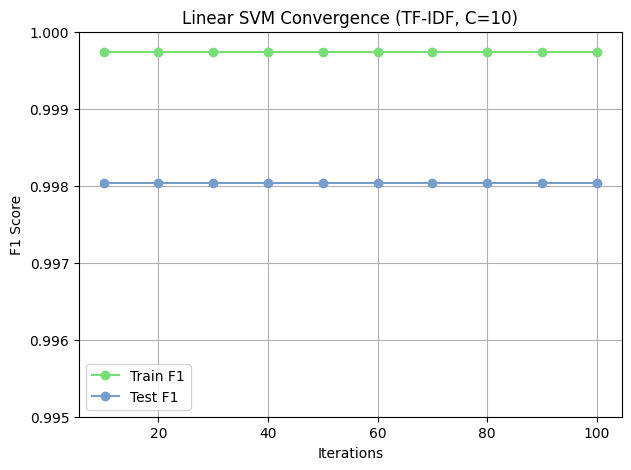

In [27]:
plt.figure(figsize=(7,5))
plt.plot(results_df["Iterations"], results_df["Train F1"], 'o-', label='Train F1', color='#77DD77')
plt.plot(results_df["Iterations"], results_df["Test F1"], 'o-', label='Test F1', color='#779ECB')
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.title("Linear SVM Convergence (TF-IDF, C=10)")
plt.ylim(0.995, 1.0)
plt.legend()
plt.grid(True)
plt.show()

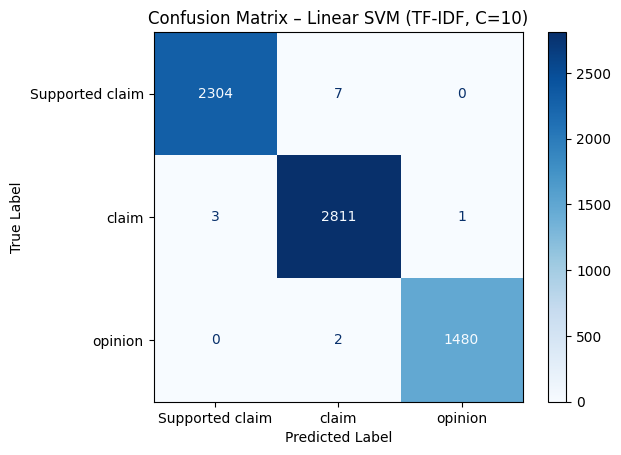

In [29]:
y_pred = svm_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix – Linear SVM (TF-IDF, C=10)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Saving the model

In [ ]:
joblib.dump(svm_model, "linear_svm_tfidf_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!
